# Entrenamiento CNN


# Importando dataset


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.applications.mobilenet import preprocess_input
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing import image
from mlxtend.evaluate import confusion_matrix
import matplotlib.image as mpimg

In [2]:
#Limpiamos todo en caso de un nuevo entrenamiento
K.clear_session()
# Damos las direcciones de las carpetas que contienen los datasets
data_entrenamiento = './dataset_reducida/train'
data_validacion = './dataset_reducida/validation'

In [3]:
#Hyper parametros
epocas = 20 #cantidad de iteraciones
longitud, altura = 200, 200 #longitud y altura de la convolucion
batch_size = 32 #numero de imagenes que procesa la pc en cada uno de los pasos
#pasos_entramiento = cada epoca se va a dividir en XX pasos
#pasos_validacion = cada epoca se va a validar YY, sirve para verificar que se esta aprendiendo
filtrosConv1 = 32 #numero de filtros que aplicaremos tras la primera convolucion
filtrosConv2 = 64 #tras segunda segunda convolucion
tam_filtro1 = (3,3)
tam_filtro2 = (2,2)
tam_pool = (2,2) #para mejorar avance de la convolucion
clases = 3
lr = 0.0005

In [4]:
entrenamiento_datagen = ImageDataGenerator(
    rescale = 1. / 255, #reescalamos los pixeles de la imagen entre 0 y 1, 
    shear_range = 0.3, #inclinar imagenes, porque las imagenes no siempre vienen derechas,
    zoom_range = 0.3, #porciones de imagenes,
    horizontal_flip = True)

validacion_datagen = ImageDataGenerator(rescale = 1. / 255)

#va abrir y preparar toda la carpeta de entrenamiento
imagen_entrenamiento = entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')

#va abrir y preparar toda la carpeta de validacion
imagen_validacion = validacion_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')

print(imagen_entrenamiento.class_indices)

Found 1847 images belonging to 3 classes.
Found 452 images belonging to 3 classes.
{'high': 0, 'low': 1, 'mid': 2}


In [5]:
pasos_entrenamiento = imagen_entrenamiento.n//imagen_entrenamiento.batch_size
pasos_validacion = imagen_validacion.n//imagen_validacion.batch_size

In [6]:
#Crear la red neuronal convolucional
cnn = Sequential() #varias capas aplicadas entre ellas
cnn.add(Conv2D(filtrosConv1, tam_filtro1, padding = 'same', input_shape=(longitud,altura,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size = tam_pool))

cnn.add(Conv2D(filtrosConv2, tam_filtro2, padding = 'same'))
cnn.add(MaxPooling2D(pool_size = tam_pool))

cnn.add(Flatten()) #imagen profunda la vamos a hacer plana, es decir, solo una dimension
cnn.add(Dense(256, activation = 'relu')) #añadimos una capa que va a conectar la anterior y las sgts 256 conexiones
cnn.add(Dropout(0.5)) #apagamos 50% de as neuronas cada paso, evitando sobreajuste
cnn.add(Dense(clases,activation = 'softmax')) #indica que prob tiene cada clase


2022-10-30 16:59:35.870577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 16:59:36.037356: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
cnn.compile(loss='categorical_crossentropy',
           optimizer=optimizers.Adam(lr=lr),
           metrics=['accuracy'])
H = cnn.fit_generator(
    imagen_entrenamiento,
    steps_per_epoch=pasos_entrenamiento,
    epochs = epocas,
    validation_data = imagen_validacion,
    validation_steps= pasos_validacion)

/home/mono/.conda/envs/t1env/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/home/mono/.conda/envs/t1env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == "__main__":


Epoch 1/20
57/57 [==============================] - 302s 5s/step - loss: 2.1805 - accuracy: 0.4496 - val_loss: 0.8981 - val_accuracy: 0.5647
Epoch 2/20
57/57 [==============================] - 239s 4s/step - loss: 0.9801 - accuracy: 0.5284 - val_loss: 0.9488 - val_accuracy: 0.5379
Epoch 3/20
57/57 [==============================] - 256s 4s/step - loss: 0.9328 - accuracy: 0.5416 - val_loss: 0.8829 - val_accuracy: 0.5737
Epoch 4/20
57/57 [==============================] - 203s 4s/step - loss: 0.9315 - accuracy: 0.5405 - val_loss: 0.8735 - val_accuracy: 0.5112
Epoch 5/20
57/57 [==============================] - 201s 4s/step - loss: 0.9132 - accuracy: 0.5620 - val_loss: 0.8105 - val_accuracy: 0.6071
Epoch 6/20
57/57 [==============================] - 198s 3s/step - loss: 0.8797 - accuracy: 0.5747 - val_loss: 0.7849 - val_accuracy: 0.6027
Epoch 7/20
57/57 [==============================] - 195s 3s/step - loss: 0.8662 - accuracy: 0.5950 - val_loss: 0.7729 - val_accuracy: 0.6473
Epoch 8/20
57

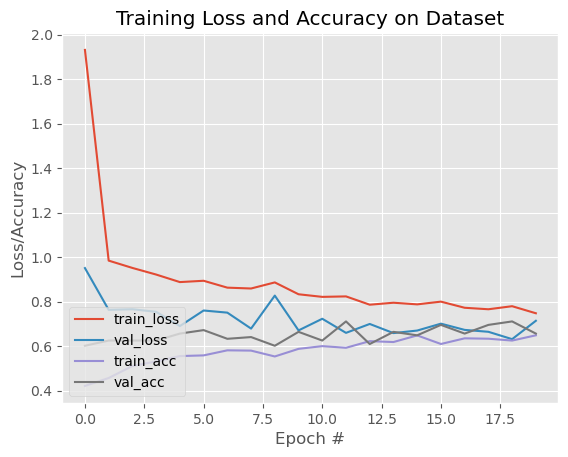

In [9]:
N = epocas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,N),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,N),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,N),H.history["val_accuracy"],label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")